### JSALT'23 Computer Lab Part II

- In this part, we will use simple strategies to analyze and visualize human-to-human task-oriented conversations.

- For this, we will use a standard dataset called MultiWoz v2.2, that covers several task-oriented domains such as
restaurant, taxi, hotel, train bookings, tourist attractions, and even combination of these domains.

- However, we will use only a subset of the conversations and try to find a strucutre within the conversations

### Hardware
- We can use either Google collab or Kaggle notebooks or your personal laptops (with a GPU)
- Some part of the assignment requires a GPU

### Install required packages in a Kaggle notebook
```
! pip3 install sentence-transformers==2.2.2
! pip3 install datasets==2.12
! pip3 install scikit-learn==1.2.2
! pip3 install graphviz
! pip3 install matplotlib
```

In [1]:
! pip3 install sentence-transformers==2.2.2
! pip3 install datasets==2.12
! pip3 install scikit-learn==1.2.2
! pip3 install graphviz
! pip3 install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from typing import List, Union
from copy import deepcopy
import tqdm

In [8]:
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

In [12]:
import numpy as np

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

from scipy import sparse

import graphviz

import matplotlib.pyplot as plt

In [13]:
def load_multiwoz_subset(domain):
    """Pick a subset of dialogues with given domain only.
    Since each dialogue can contain multiple domains, the selected
    subset will still be multi-domain with the given domain being dominant"""

    multiwoz_dset = load_dataset("multi_woz_v22")

    subset_ixs = []  # list
    subset_utts = []  # nested list

    services_selected = []

    for i, conv in enumerate(multiwoz_dset["train"]):
        # keys: dialogue_id, services, turns
        if domain in conv["services"]:
            utts = conv["turns"]["utterance"]
            subset_utts.append(utts)
            subset_ixs.append(i)
            services_selected.append("_".join(sorted(conv['services'])))

    return subset_utts, subset_ixs, services_selected

In [20]:
# In Multiwoz dataset, conversations with a single domain rarely exist.
# Most of the convsersations involve multiple domains, hence "multi"-woz

domain = 'restaurant'

domain_convs, domain_ixs, services_selected = load_multiwoz_subset(domain)
print('Conversations with domain:', domain, '=', len(domain_convs))
print("Services selected\n ", "\n  - ".join(list(set(services_selected))))

utts_per_conv = np.asarray([len(conv) for conv in domain_convs])
print('\nTotal number of utterances (sentences):', np.sum(utts_per_conv))
avg_utts_per_conv = np.mean(utts_per_conv)
print('Average number of utts per conversation: {:.1f}'.format(avg_utts_per_conv))

  0%|          | 0/3 [00:00<?, ?it/s]

Conversations with domain: restaurant = 3836
Services selected
  attraction_restaurant_taxi_train
  - restaurant_taxi_train
  - attraction_restaurant_train
  - attraction_hotel_restaurant_train
  - attraction_restaurant
  - hotel_restaurant_taxi_train
  - attraction_hotel_restaurant_taxi
  - restaurant_train
  - attraction_restaurant_taxi
  - hotel_restaurant_taxi
  - attraction_bus_restaurant
  - restaurant_taxi
  - hotel_restaurant_train
  - restaurant
  - attraction_hotel_restaurant
  - hotel_restaurant

Total number of utterances (sentences): 54446
Average number of utts per conversation: 14.2


In [22]:
def extract_sentence_embeddings(sentences, model_name, out_emb_file, max_s=512):
    """Extract sentence embeddings using one of the models from Sentence_transformers
    See https://huggingface.co/sentence-transformers for list of supported models.

    Args:
    -----
        sentences (list): List of sentences where every sentence in a plain string
        model_name (str): Should match the name from sentence_transformers (eg: sentence-transformers/LaBSE)
        out_emb_file (str): File where the embeddings are saved, so that we can
            load them from the disk
        max_s (int): Maximum sequence length, usually 512, but can be higher/lower of different models.
    """

    if os.path.exists(out_emb_file):
        embs = np.load(emb_file)
        print('Re-loading sentence embeddings from file:', out_emb_file,)
        print('  Embeddings shape:', embs.shape)

        if embs.shape[0] != len(sentences):
            print("Loaded embeddings {:d} != number of sentences {:d}.".format(embs.shape[0], len(sentences)),
                  "Probably the embeddings loaded from the disk correspond to different set of sentences.")

    else:

        print("Extracting embeddings..")

        model = SentenceTransformer(model_name)

        # this should not exceed the max seq length that was used
        # while training the model
        model.max_sequence_length = max_s
        # Consider using a GPU accelarator for this step
        # and uncomment the following line
        model.cuda()

        embs = model.encode(sentences)

        np.save(emb_file, embs)
        print("Saved embeddings", embs.shape, "to", emb_file)

    return embs


### Strategies to represent the dialogues within in conversation

1. Treat each utterance independent of others (naive)
2. Consider the `n` past history (or context) to represent current utterance.
3. Consider the `n` past and `n` future utterances.

#### Strategy 1: naive

In [23]:
# we will flatten the conversations into independent sentences, but keeping the order
# We can try better strategies to obtain sentence embeddings,
# eg: concatenating 1 or 2 previous sentences to the current one, etc.

# strategy 1: treat every sentence independent of each other
sentences_indep = []
for sents in domain_convs:
    sentences_indep.extend(sents)
print("Flattened sentences (independent):", len(sentences_indep))

os.makedirs("cluster_multiwoz/", exist_ok=True)

model_name = "sentence-transformers/LaBSE"
emb_file = f"cluster_multiwoz/{domain}_sent_embs.npy"

embs_indep = extract_sentence_embeddings(sentences_indep, model_name, emb_file)

Flattened sentences (independent): 54446
Re-loading sentence embeddings from file: cluster_multiwoz/restaurant_sent_embs.npy
  Embeddings shape: (54446, 768)


#### Strategy 2: Combine past utterance with the current one

In [24]:
# Running this cell will override the embeddings from previous cell
# appending previouse sentence to the current one and extracting embeddings
# sent_0, sent_0+sent_1,
# Strategy 2: Prepend the current utterance with past utterance

sentences_hist1 = []
for sents in domain_convs:
    history = ""
    for i, sent in enumerate(sents):
        sentences_hist1.append(history + sent)
        history = sent + " "
print("Sentences prepended with past 1 history:", len(sentences_hist1))

model_name = "sentence-transformers/LaBSE"
emb_file = f"cluster_multiwoz/{domain}_accum_h1_sent_embs.npy"

embs_hist1 = extract_sentence_embeddings(sentences_hist1, model_name, emb_file)

Sentences prepended with past 1 history: 54446
Re-loading sentence embeddings from file: cluster_multiwoz/restaurant_accum_h1_sent_embs.npy
  Embeddings shape: (54446, 768)


### Selecting a smaller subset from the `domain=restaurant`
- Skip this step for the first time.
- Try to visualize the clusters with all the conversations, later, pick only a subset and visualize again.
- In the following example, we will consider even a smaller subset, i.e., by selecting services that
based on `restaurant` and `restaurant + taxi` booking.
- In reality, we can assume that we will have such kind of metadata available for conversations.

In [25]:
# Select only embeddings that belong to few services
#
def select_subset_serivces(subset_services, embeddings):

    subset_sents = []
    subset_embs = []
    subset_domain_convs = []

    j = 0
    for i, serv in enumerate(services_selected):
        # print(i, serv, len(domain_convs[i]), "::", j, "->", j+len(domain_convs[i]))
        if serv in subset_services:
            # print(i, serv, "::", j, "->", j+len(domain_convs[i]), '::', embs[j:j+len(domain_convs[i])].shape)

            subset_domain_convs.append(domain_convs[i])
            subset_embs.append(embeddings[j:j+len(domain_convs[i]),])

            subset_sents.extend(domain_convs[i])

        j += len(domain_convs[i])

    return subset_domain_convs, subset_sents, subset_embs



subset_services = ("restaurant", "restaurant_taxi")

# we are can decide which embeddings to send
# embeddings from strategy 1 or strategy 2 or custom strategy..
subset_domain_convs, subset_sents, subset_embs = select_subset_serivces(subset_services, embs_hist1)

print(f"# Subset of domain {domain} conversations:", len(subset_domain_convs))
print("# Subset sentences:", len(subset_sents))

subset_embs = np.concatenate(subset_embs)
print('Corresponding subset embeddings:', subset_embs.shape)


# Subset of domain restaurant conversations: 1275
# Subset sentences: 11110
Corresponding subset embeddings: (11110, 768)


In [26]:
def compute_transitions(domain_convs: List[list], cluster_ixs: np.ndarray) -> np.ndarray:
    """Compute the transitions from one cluster to the other, based on
    the actual conversation/dialogue flow. Also compute the assigment of sentence embeddings to
    the cluster indices - mainly start of dialogue and end of dialogue sentences"""

    print('Computing transition matrix ..')
    n_clusters = np.unique(cluster_ixs).size
    print(' n_clusters', n_clusters)

    soc_clusters = []  # start of conversation clusters
    eoc_clusters = []  # end of conversation clusters
    # transitions: row(from) - col(to)
    transitions = np.zeros(shape=(n_clusters, n_clusters))

    i = 0
    k = 0
    while i < len(domain_convs): # iterate over conversations/dialogs, where each conv is a seq of utts
        j = 0
        prev_cix = -1
        while j < len(domain_convs[i]):  # iterate over utts in the current dialogue

            cix = cluster_ixs[k]

            if j == 0:  # start of conversation
                soc_clusters.append(cix)
            else:
                # from, to
                transitions[prev_cix, cix] += 1

            prev_cix = deepcopy(cix)

            k += 1
            j += 1

        # end of conversation
        eoc_clusters.append(prev_cix)

        i += 1

    return transitions, np.asarray(soc_clusters), np.asarray(eoc_clusters)


def get_cluster_assignments(occurrences):
    """Get percentage of embeddings assigned to each cluster"""

    ixs, count = np.unique(occurrences, return_counts=True)
    max_ix = np.argmax(count)
    print(
        "Cluster ix:",
        np.array2string(ixs, precision=0, formatter={'int_kind': lambda x: "%4d" % x}, separator=' |')
    )
    print(
        "Percentage:",
        np.array2string(count * 100/count.sum(), precision=1,
                        formatter={'float_kind': lambda x: "%4.1f" % x},
                        separator=' |')
    )
    print("{:.1f} % from cluster index {:d} is the most dense.".format(count[max_ix]*100./count.sum(), ixs[max_ix]))
    return count/count.sum(), ixs

#### Clustering with k-means
- Here we will cluster the subst of the embeddings using simple k-means clustering.
- You may also try other clustering strategies based on Gaussian Mixture Models or even neural network based models.

In [27]:
# you may play with this number, but it is better to keep it between [avg_utts_per_conv/2, avg_utts_per_conv x 2]
print("Avg. utts per conversation: {:.0f}".format(avg_utts_per_conv))


def run_kmeans(n_clusters, embs, seed=12345):
    """Cluster the given embeddings into the specified number of clusters
    and return the hard cluster assignments"""

    print("Clustering", embs.shape[0], "embeddings into", n_clusters, "clusters with k-means..")

    norm_embs = preprocessing.normalize(embs)
    print("  Normalizing embeddings to have unit length..")

    kmeans = KMeans(n_clusters=n_clusters, random_state=seed, max_iter=1000)
    pred_ixs = kmeans.fit_predict(norm_embs)
    print('.. done')

    return pred_ixs


Avg. utts per conversation: 14


In [28]:
# pred_ixs = run_kmeans(12, embs_indep)  # kmeans with embeddings from strategy 1
pred_ixs = run_kmeans(12, embs_hist1)  # kmeans with embeddings from strategy 2
# pred_ixs = run_kmeans(12, subset_embs)  # kmeans with subset of embeddings strategy 2

Clustering 54446 embeddings into 12 clusters with k-means..
  Normalizing embeddings to have unit length..


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.. done


In [30]:
# Check if the embeddings are more or less equally distributed

_ = get_cluster_assignments(pred_ixs)

Cluster ix: [   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11]
Percentage: [ 6.1 | 7.2 | 5.7 | 5.4 | 8.5 | 9.2 | 9.4 |11.5 | 9.4 |13.3 | 4.0 |10.2]
13.3 % from cluster index 9 is the most dense.


In [31]:
trans, soc, eoc = compute_transitions(domain_convs, pred_ixs)  # strategy 1
# trans, soc, eoc = compute_transitions(domain_convs, pred_ixs)  # strategy 2
# trans, soc, eoc = compute_transitions(subset_domain_convs, pred_ixs)  # strategy 2 with subset
print("Transition matrix:", trans.shape)
for i in range(trans.shape[0]):
    trans[i, :] /= trans[i, :].sum()

print("\nStart of conversation..")
# get the clusters where the conversation usually BEGIN
soc_prob, soc_ixs = get_cluster_assignments(soc)


print("\nEnd of conversation..")
# get the clusters where the conversation usually END
eoc_prob, eoc_ixs = get_cluster_assignments(eoc)

Computing transition matrix ..
 n_clusters 12
Transition matrix: (12, 12)

Start of conversation..
Cluster ix: [   0 |   1 |   2 |   3 |   4 |   6 |   7 |   8 |   9 |  11]
Percentage: [ 0.0 | 7.2 | 0.2 |64.9 | 8.7 | 9.9 | 3.9 | 0.2 | 4.8 | 0.2]
64.9 % from cluster index 3 is the most dense.

End of conversation..
Cluster ix: [   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11]
Percentage: [46.9 | 0.4 | 0.9 | 0.1 | 0.3 | 0.7 | 0.3 | 1.0 | 1.3 | 0.5 |46.3 | 1.1]
46.9 % from cluster index 0 is the most dense.


### Let us visualize the clusters and the transitions

In [32]:
# Let us visualize the clusters and the transitions
# We can set thresholds on the transition scores which will enable to control
# the arcs that will be drawn

def visualize_graph(trans, soc_prob, soc_ixs, eoc_prob, eoc_ixs, s_thresh=0.1, thresh=0.1):
    # low threshold will show many arcs, higher threshold will only show dominant arcs
    # s_thresh - threshold for drawing begin, end transitions
    # thresh -  threshold for drawing an intermediate arc

    # see https://graphviz.readthedocs.io/en/stable/  for more documentation on graphviz

    dot = graphviz.Digraph(f"MutliWoz_{domain}", format='png', graph_attr={'rankdir':'LR'})  # initialize a graph

    n_clusters = trans.shape[0]

    # add BEGIN and END nodes
    dot.node('BEGIN', shape='doublecircle')
    dot.node('END', shape='doublecircle')

    # Add a node representing each cluster
    for i in range(n_clusters):
        dot.node(str(i), shape='circle')

    # draw arrows from BEGIN to that cluster(s) where the start sentences live
    # given that they are above the `s_thresh`
    for i, prob in enumerate(soc_prob):
        if prob > s_thresh:
            dot.edge('BEGIN', str(soc_ixs[i]), label="{:.2f}".format(prob))
            dot.node(str(soc_ixs[i]), fillcolor='cyan', style='filled')

    # draw arrows from cluster(s) where the end sentences live to the END node
    for i, prob in enumerate(eoc_prob):
        if prob > s_thresh:
            dot.edge(str(eoc_ixs[i]), 'END', label="{:.2f}".format(prob))
            dot.node(str(eoc_ixs[i]), fillcolor='pink', style='filled')

    # draw intermediate arcs among the clusters where transitions > thresh

    for row_ix in range(trans.shape[0]):  # row_ix represent FROM, col_ixs represent TO
        row_trans = trans[row_ix, :] / trans[row_ix, :].sum()
        thresh_ixs = np.where(row_trans > thresh)
        if thresh_ixs[0].size > 0:
            # print(row_ix, '->', thresh_ixs)
            for col_ix in thresh_ixs[0]:
                dot.edge(str(row_ix), str(col_ix), label="{:.2f}".format(row_trans[col_ix]))

    # show the image within the notebook
    # dot.view() will open the image in an external window
    return dot

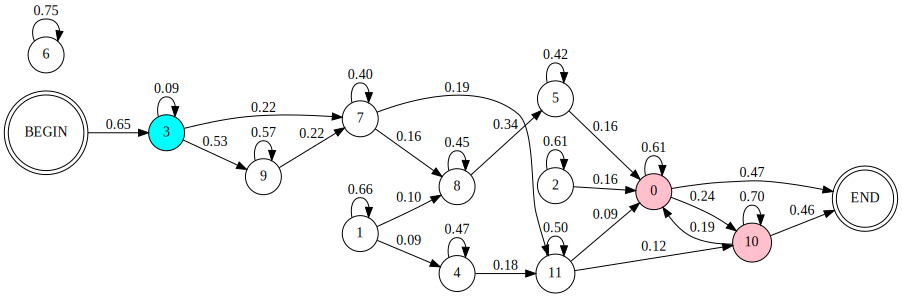

In [33]:
dot = visualize_graph(trans, soc_prob, soc_ixs, eoc_prob, eoc_ixs, s_thresh=0.1, thresh=0.09)
dot

### What does each cluster (node) actually represent :
* Can we get any representative utterances from the dialogues ?
* Can we get any representative words (word cloud) for each cluster ?
* Can we automatically identify the underlying intents / slot values for each cluster ?

In [34]:
def get_most_representative_words(sentences: list, pred_ixs: np.ndarray):
    """Get most representative words per each cluster, based on
    relative counts normalized to yield probabilities
    """
    n_clusters = np.max(pred_ixs) + 1

    count_vect = CountVectorizer(stop_words='english', lowercase=True, strip_accents=None, min_df=2)
    counts = count_vect.fit_transform(sentences)

    print('counts (n_sentences x vocab_size):', counts.shape)
    int2vocab = {}
    for vocab, idx in count_vect.vocabulary_.items():
        int2vocab[idx] = vocab

    # cluster assignments to sentences in sparse format
    # shape = (n_clusters x n_sentences)
    sparse_cixs = sparse.csr_matrix((np.ones(len(pred_ixs,)), (pred_ixs, np.arange(len(pred_ixs)))))

    # cumulative word count per cluster
    wc_per_cluster = sparse_cixs.dot(counts)
    print('n_clusters x vocab_size:', wc_per_cluster.shape, type(wc_per_cluster))

    prob_per_cluster = wc_per_cluster / wc_per_cluster.sum(axis=0)

    # print(prob_per_cluster.shape)
    print()

    top_k = 15  # print TOP K words per cluster

    for i in range(n_clusters):
        sort_ixs = np.argsort(prob_per_cluster[i, :].A.squeeze())[::-1]
        print("= Cluster", i, end="=\n ")
        for j in range(top_k):
            print(int2vocab[sort_ixs[j]], end=", ")
        print("\n")


In [35]:
get_most_representative_words(sentences_hist1, pred_ixs)


counts (n_sentences x vocab_size): (54446, 8468)
n_clusters x vocab_size: (12, 8468) <class 'scipy.sparse._csr.csr_matrix'>

= Cluster 0=
 confirming, awe, maintenance, inquiries, thnks, thankl, jaja, assisted, helpline, demand, obtain, interaction, hasn, apology, alls, 

= Cluster 1=
 frills, quest, hostel, candidates, hotal, inspire, foru, commit, motel, compare, guesthoise, cityroomzs, valued, paring, complimentary, 

= Cluster 2=
 07799680227, 07656739082, 07658312417, 07658935119, 0766024206, 07664553144, 07669345707, 07669997265, 07670621306, 07672513904, 07673977358, 07674543654, 07675725181, 07675976580, 07690050237, 

= Cluster 3=
 blow, buses, scale, medium, sum, competitors, almentum, constrained, strip, playground, mutiple, darling, restrant, restauant, decent, 

= Cluster 4=
 exhibit, expresses, pizze, complexes, excitement, guidance, exhange, atractions, attract, uk, belt, kill, topic, directory, africa, 

= Cluster 5=
 zzaa5fy2, sei1me8k, da8chtds, dakq9zbn, daqee9bh, db

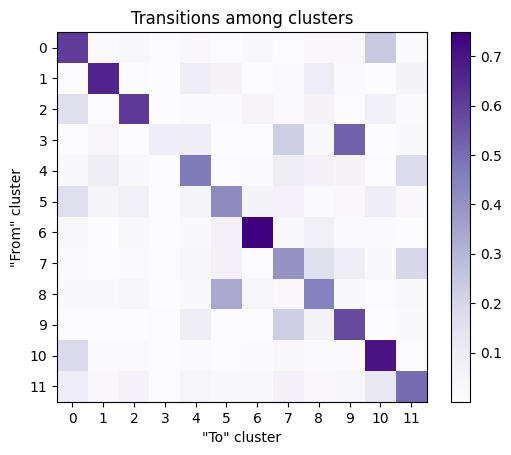

In [37]:
fig = plt.figure(num=1)

n_clusters = np.max(pred_ixs) + 1

# https://matplotlib.org/stable/tutorials/colors/colormaps.html
im = plt.imshow(trans, cmap='Purples')

plt.xticks(np.arange(n_clusters))
plt.yticks(np.arange(n_clusters))

plt.ylabel("\"From\" cluster")
plt.xlabel("\"To\" cluster")

plt.title("Transitions among clusters")

_ = plt.colorbar(im)

- At this point, you can stop and go back and try
1. different strategies to represent sentences
2. and/or use different model to extract embeddings
3. and/or use different number of clusters or clustering techniques such as Agglomerative Hierarchical Clustering, etc.

# Advanced:
- Below, we can train a model to represent our data, i.e., sentences from one of the strategies.
- Then, we can extract most representative words per cluster.

### The following steps describe the generative process of our model

1. Given a vocabulary of size $W$, and corresponding $k$ dimensional-word embeddings or a $k$-dimensional subspace defined by

    $\mathbf{E} \in \mathbb{R}^{W \times k}$

2. For each document $d=1 \ldots D$

    Sample a document-specific embedding as follows:

    $\mathbf{a}_d \sim \mathcal{N}(\mathbf{a}_d \mid \mathbf{0}, \mathbf{I})$

    Obtain the distribution of words in each document $\boldsymbol{\theta}_d$ by normalizing

    $\boldsymbol{\theta}_d = \mathrm{softmax}(\mathbf{b} + \mathbf{E} \, \mathbf{a}_d)$

    where $\mathbf{b}$ is a $V$ dimensional vector representing bias.

    Generate a vector of words of a document (draw $N_d$ tokens independently) by sampling

    $\mathbf{x}_d \sim \mathrm{Multinomial}(\boldsymbol{\theta}_d, N_d) $

$\mathbf{x}_d$ for $d=1 \ldots D$ put row-wise in matrix $\mathbf{X}$ represents the document-by-word statistics of the dataset.

### Reality

In reality, we do not generate the data, instead, given the document-by-word counts $\mathbf{X}$ (rows represent document indices, and columns represent word indices), we would like to estimate the word embedding matrix $\mathbf{E}$, bias vector $\mathbf{b}$ and document embeddings $\mathbf{a}_d, \forall \, d=1 \ldots D$, that best explains (maxmizes the likelihood) the given (observed) counts $\mathbf{X}$.

### Likelihood

Since we assumed each document $d$ is sampled from a $\mathrm{Multonomial}$ distribution with parameters $\boldsymbol{\theta}_d$, we can compute the likelihood of a document as

$p(\mathbf{x}_d \mid \boldsymbol{\theta}_d) = \prod_{i=1}^{W} \theta_{di} ^ {x_{di}}$

or the log of the likelihood is

$
\log p(\mathbf{x}_d \mid \boldsymbol{\theta}_d) = \sum_{i} x_{di} \log (\theta_{di}) \\
\qquad \qquad \quad = \sum_{i} x_{di} \log \Big( \frac{\exp\{b_i + \mathbf{e}_i^{T} \mathbf{a}_d\}}{\sum_{j=1}^{W}\exp\{b_j + \mathbf{e}_j^{T} \mathbf{a}_d\}} \Big) \\
\qquad \qquad \quad = \sum_{i} x_{di} \Big[(b_i + \mathbf{e}_i^{T} \mathbf{a}_d) - \log \big(\sum_{j}\exp\{b_j + \mathbf{e}_j^{T} \mathbf{a}_d\} \big) \Big]
$


Log-likelihood for all the documents is the summation over individual log-likelihoods

$\mathcal{L} = \sum_{d=1}^{D} \log p(\mathbf{x}_d \mid \boldsymbol{\theta}_d) \\
\,\,\,\, = \sum_{d=1}^{D} \sum_{i} x_{di} \Big[(b_i + \mathbf{e}_i^{T} \mathbf{a}_d) - \log \big(\sum_{j}\exp\{b_j + \mathbf{e}_j^{T} \mathbf{a}_d\} \big) \Big]
$


In [38]:
from scipy.special import log_softmax, logsumexp

class Model(torch.nn.Module):
    """Model defintion, parameters and helper fucntions to compute log-likelihood"""

    def __init__(self, D: int, W: int, K: int, doc_embs: Union[None, np.ndarray]=None):
        """Initialize our model

        Args:
            D: number of documents
            W: vocab size / number of words
            K: embedding dimension / subspace
        """

        super().__init__()

        self.D = D
        self.W = W
        self.K = K

        # word embeddings matrix / subspace
        n1 = 1. / np.sqrt(K)
        n2 = 1. / np.sqrt(W)
        self.E = torch.nn.Parameter(
            torch.from_numpy(
                np.random.uniform(-n2, n1, size=(W, K))).to(dtype=torch.float32)
        )

        # bias vector
        self.b = torch.nn.Parameter(
            torch.from_numpy(np.random.randn(W, 1)  * 0.001).to(dtype=torch.float32)
            )

        # document embeddings
        if isinstance(doc_embs, np.ndarray):
          if doc_embs.shape[1] == K:
              doc_embs = doc_embs.T
          self.A = torch.nn.Parameter(
              torch.from_numpy(doc_embs), requires_grad=False
              )  # requires_grad = False
        else:
          n3 = 1. / np.sqrt(D)
          self.A = torch.nn.Parameter(
              torch.from_numpy(np.random.uniform(-n1, n3, size=(K, D))).to(dtype=torch.float32)
              )

    def __repr__(self):
        s = f"""Model params
        Word embs  : {self.E.shape}, Requires grad: {self.E.requires_grad}
        bias vector: {self.b.shape}, Requires grad: {self.b.requires_grad}
        Doc  embs  : {self.A.shape}, Requires grad: {self.A.requires_grad}"""
        return s

    def init_bias_with_log_unigram_dist(self, X):
        """We will initialize the bias vector with log of unigram distribution over vocabulary.
        This should help us with better initialization.

        b = \log (\sum_d x_d) / (\sum_d \sum_i x_{di})
        """

        # if X is sparse matrix, X.A gives the dense version of it in numpy array format
        if isinstance(X, np.ndarray):
            X = X + 1e-08  # to avoid zeros
        else:
            X = X.A + 1e-08  # to avoid any zeros

        # we would like b to of size (W, 1)
        self.b[:, 0].data = torch.from_numpy(np.log(X.sum(axis=0) / X.sum()))

    def compute_log_thetas(self, sanity_check=False):
        """Compute log of thetas, where theta_d is the unigram distribution over document `d` estiamted from
        the current params (word-embedding matrix, bias vector) and document embedding a_d. """

        mat = self.b + (self.E @ self.A)  # shape is W x D
        mat = mat.T  # shape is D x W

        # log_norm = torch.logsumexp(mat, dim=1, keepdim=True)
        # log_thetas = mat - log_norm

        # the following single step is same the two above steps combined
        log_thetas = torch.nn.functional.log_softmax(mat, dim=1)  # shape is D x W

        if sanity_check:
            # sanity-check
            # since each document is a proper distribution, it should sum upto 1
            # sum of the matrix should be equal to number of documents
            print("Sanity check for log-thetas:",
                torch.allclose(torch.exp(log_thetas).sum(), self.D)
            )

        return log_thetas

    def compute_neg_log_likelihood(self, row_ixs, col_ixs, values):
        """Compute negative log-likelihood of the data, given the current parameters / embeddings

        Each summation could be implemented using a for-loop but that would very slow,
        since we have every thing stored in matrices and a sparse matrix, we will do it via
        matrix muliplications and additions.

        Args:
            row_ixs (torch.LongTensor): Row indices (docs)
            col_ixs (torch.LongTensor): Col indices (words)
            values (torch.FloatTensor): counts (occurrences)

        Returns:
            float: log-likelihood of the data
        """

        log_thetas = self.compute_log_thetas()

        llh = (log_thetas[row_ixs, col_ixs] * values).sum()

        return -1.0 * llh


In [39]:
def train(model, X, train_iters, opt, device):
    """Training scheme for the model"""

    rixs, cixs = X.nonzero()
    rixs = torch.from_numpy(rixs).long().to(device=device)
    cixs = torch.from_numpy(cixs).long().to(device=device)
    data = torch.from_numpy(X.data).to(device=device)

    with torch.no_grad():
        initial_llh = model.compute_neg_log_likelihood(rixs, cixs, data)
        print("Initial neg. log-likelihood:", initial_llh.detach().cpu().numpy())

        print("Initializing bias vector to log-unigram distribution.")
        model.init_bias_with_log_unigram_dist(X)

        new_init_llh = model.compute_neg_log_likelihood(rixs, cixs, data)
        print("New init neg. log-likelihood:", new_init_llh.detach().cpu().numpy())


    llhs = [initial_llh.detach().cpu().numpy(), new_init_llh.detach().cpu().numpy()]

    # pbar = tqdm(np.arange(1, train_iters+1).tolist())

    tran = tqdm.trange(
        train_iters, desc='Neg Log-likelihood {:10.1f} | Training progress'.format(llhs[-1]), leave=True
        )

    for i in tran:

        opt.zero_grad()

        llh_ei = model.compute_neg_log_likelihood(rixs, cixs, data)

        llh_ei.backward()

        opt.step()

        tran.set_description("Neg Log-likelihood {:10.1f} | Training progress".format(llh_ei))
        tran.refresh() # to show immediately the update

        llhs.append(llh_ei.detach().cpu().numpy())


    return model, llhs


In [40]:
# We will used only a subset of sentences from strategy 2

count_vect = CountVectorizer(stop_words=None, lowercase=False, strip_accents=None, min_df=1)
DbyW = count_vect.fit_transform(subset_sents)
print('Counts (DbyW)', DbyW.shape)

int2vocab = {}
for word, idx in count_vect.vocabulary_.items():
    int2vocab[idx] = word

Counts (DbyW) (11110, 2724)


In [41]:
np.random.seed(99)

# higher the embedding-dim, more semantic information could be captured, but at the same time
# increases the number of parameters and also training time and memory requriements.

emb_dim = subset_embs.shape[1]  # embedding dim
print('Embedding dim of sentences:', emb_dim)

model = Model(DbyW.shape[0], DbyW.shape[1], emb_dim, subset_embs)

print(model)

train_iters = 200

# higher learning rate can make big steps, but can overshoot, one can use backtracking approach to make smaller steps.

# You can play with various learning rate and see how quickly the model converges
learning_rate = 0.01

# Create an optimizer
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)


Embedding dim of sentences: 768
Model params
        Word embs  : torch.Size([2724, 768]), Requires grad: True
        bias vector: torch.Size([2724, 1]), Requires grad: True
        Doc  embs  : torch.Size([768, 11110]), Requires grad: False


In [42]:
# Let's train the model
# Run this cell again to continue traning for more iterations
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'

device = torch.device("cuda")
model.cuda()

model, llhs = train(model, DbyW, train_iters, opt, device)

Initial neg. log-likelihood: 976877.75
Initializing bias vector to log-unigram distribution.
New init neg. log-likelihood: 976877.75


Neg Log-likelihood   443788.5 | Training progress: 100%|██████████| 200/200 [00:06<00:00, 29.88it/s]


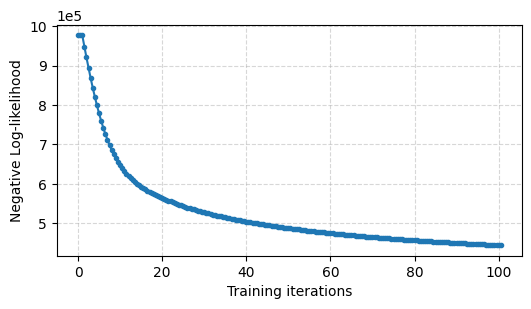

In [43]:
def plot_log_likelihood(llhs, fig_num):

    plt.figure(fig_num, figsize=(6, 3))
    plt.plot(np.arange(0, len(llhs)/2., 0.5), llhs, '.-')

    plt.xlabel('Training iterations')
    plt.ylabel('Negative Log-likelihood')

    plt.ticklabel_format(axis='y', style='sci', scilimits=(5, 5))
    plt.grid(alpha=0.5, linestyle='--')
    plt.show()

plot_log_likelihood(llhs, 10)

In [44]:
# Cluster and Get more representative words using the trained word embeddings

def cluster_and_get_representative_words(int2vocab, model, n_clusters):

    embs = model.A.T
    embs = embs.detach().cpu().numpy()
    print('Doc embeddings (model.A.T):', embs.shape)

    print("Clustering", embs.shape[0], "embeddings into", n_clusters, "clusters with k-means..")

    norm_embs = preprocessing.normalize(embs)
    print("  Normalizing embeddings to have unit length..")

    kmeans2 = KMeans(n_clusters=n_clusters, n_init='auto', random_state=123, max_iter=1000)
    pred_ixs2 = kmeans2.fit_predict(norm_embs)
    print('.. done')

    cluster_ixs, cluster_strength = np.unique(pred_ixs2, return_counts=True)

    cluster_strength = cluster_strength / pred_ixs2.shape[0]

    centroids = kmeans2.cluster_centers_

    print("Cluster centers:", centroids.shape)

    global_mean = np.mean(embs, axis=0)

    scores = (model.E.detach().cpu().numpy() @ (centroids - global_mean).T)
    # scores = (model.E.detach().cpu().numpy() @ centroids.T)

    topn = 15  # top N words per cluster

    print("Cluster_index (strength in %) Representative tokens\n")
    for k in range(n_clusters):
        k_ixs = np.argsort(scores[:, k])[::-1] # sort in descending order
        print("{:3d} ({:3.1f})".format(k, cluster_strength[k]*100.), end="   ")
        for i in range(topn):
            print(int2vocab[k_ixs[i]], end=", ")
        print("\n")

    print()

#     top_k = 15  # print TOP K words per cluster
#     for i in range(n_clusters):
#         sort_ixs = np.argsort(prob_per_cluster[i, :].A.squeeze())[::-1]
#         print("= Cluster", i, end="=\n ")
#         for j in range(top_k):
#             print(int2vocab[sort_ixs[j]], end=", ")
#         print("\n")

    return pred_ixs2

In [45]:
pred_ixs2 = cluster_and_get_representative_words(int2vocab, model, 12)

Doc embeddings (model.A.T): (11110, 768)
Clustering 11110 embeddings into 12 clusters with k-means..
  Normalizing embeddings to have unit length..
.. done
Cluster centers: (12, 768)
Cluster_index (strength in %) Representative tokens

  0 (8.4)   address, phone, their, postcode, number, post, give, code, its, telephone, Give, thier, Address, Sounds, venue, 

  1 (16.3)   town, center, part, restaurants, several, prefer, moderate, There, in, these, north, range, preference, price, interested, 

  2 (3.7)   01223, reached, 277977, 355166, 362525, 367660, 308681, 309147, 01223323361, 01223352500, 566188, 351880, Their, 362456, 311911, 

  3 (7.6)   welcome, Glad, pleasure, glad, allowing, Enjoy, Have, enjoy, using, calling, helped, future, contacting, You, day, 

  4 (6.7)   Goodbye, welcome, bye, Welcome, Good, goodbye, Woah, YOU, wecome, Bye, yo, Nice, talking, pleasure, Thank, 

  5 (5.3)   Park, Way, Clifton, Leisure, Road, G4, Cambridge, Hinton, Cherry, Retail, Chesterton, road, pos

In [46]:
trans2, soc2, eoc2 = compute_transitions(subset_domain_convs, pred_ixs2)  # strategy 2 with subset
print("Transition matrix:", trans2.shape)
for i in range(trans2.shape[0]):
    trans2[i, :] /= trans2[i, :].sum()

print("\nStart of conversation..")
# get the clusters where the conversation usually BEGIN
soc_prob2, soc_ixs2 = get_cluster_assignments(soc2)


print("\nEnd of conversation..")
# get the clusters where the conversation usually END
eoc_prob2, eoc_ixs2 = get_cluster_assignments(eoc2)

Computing transition matrix ..
 n_clusters 12
Transition matrix: (12, 12)

Start of conversation..
Cluster ix: [   0 |   1 |   5 |   6 |   7 |   8 |   9 |  10]
Percentage: [ 6.8 | 8.2 | 0.2 | 0.9 |76.5 | 0.2 | 7.2 | 0.2]
76.5 % from cluster index 7 is the most dense.

End of conversation..
Cluster ix: [   0 |   1 |   2 |   3 |   4 |   5 |   6 |   8 |   9 |  10 |  11]
Percentage: [ 0.5 | 1.3 | 0.5 |44.0 |47.5 | 0.5 | 0.4 | 1.3 | 1.2 | 1.7 | 1.2]
47.5 % from cluster index 4 is the most dense.


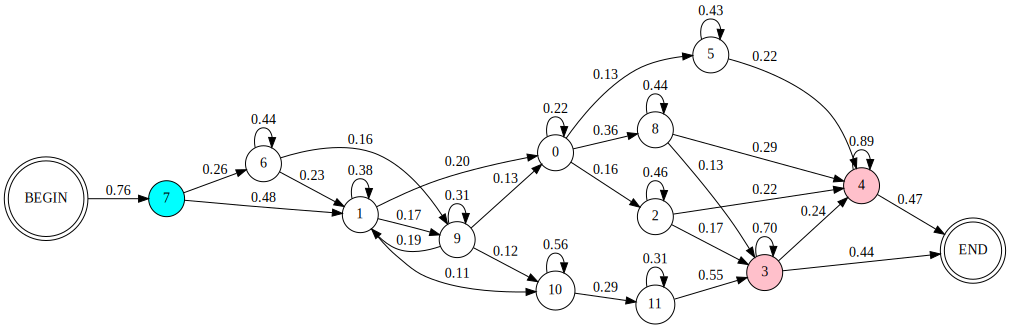

In [161]:
dot2 = visualize_graph(trans2, soc_prob2, soc_ixs2, eoc_prob2, eoc_ixs2)
dot2

In [ ]:
get_most_representative_words(subset_sents, pred_ixs2)